In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import r2_score

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

data_dir = "../data/processed/"

To use this notebook:

First run the script: ./src/data/make_dataset_rnn.py

In the next cell enter i = ? to be the dataset you want to work on (e.g. i = 2 for FD002)

Select your training weighting factor in the model construction cell with the C = ? line (e.g. C = 10)

In [2]:
i = 1
ind = i

# data loading 
train_file = np.loadtxt(data_dir+"windowed_train_FD00"+str(i)+".txt",delimiter=",")
test_file = np.loadtxt(data_dir +"standardized_test_FD00"+str(i)+".txt",delimiter=",")
train_file_stan = np.loadtxt(data_dir+"standardized_train_FD00"+str(i)+".txt",delimiter=",")

train_x = train_file[:,2:]
train_y = train_file[:,1]

train_x_stan = train_file_stan[:,2:]
train_units = train_file_stan[:,0]
train_y_stan = train_file_stan[:,1]

test_units = test_file[:,0]
test_x = test_file[:,2:]
test_y = test_file[:,1]

In [3]:
N_tws = [0,50,20,30,15]
N_tw = N_tws[ind]
num_samples = int(train_file.shape[0]/N_tw)
num_features = 24
num_features_ae = 14
print(num_samples)

data_x = torch.zeros(num_samples,N_tw,num_features)
data_y = torch.zeros(num_samples,N_tw,1)

data_x_ae = torch.zeros(num_samples,N_tw,num_features_ae)
data_y_ae = torch.zeros(num_samples,N_tw,1)

for i in range(num_samples):
    for t in range(N_tw):
        data_y[i][t][0] = torch.tensor(train_y[i*N_tw+t])
        data_x[i][t][:] = torch.tensor(train_x[i*N_tw+t,:])
        

15731


In [4]:
class EngineDataset(Dataset):
    def __init__(self,data_x,data_y):
        self.x = data_x
        self.y = data_y

    def __len__(self):
        return self.x.size()[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [5]:
batch_size = 128
train_data = EngineDataset(data_x, data_y)
train_data_ae = EngineDataset(data_x_ae,data_y_ae)
print(train_data.__len__())
print(train_data.x.size())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
train_loader_ae = DataLoader(train_data_ae,shuffle=True,batch_size =batch_size,drop_last=True)
print(next(iter(train_loader))[0].size())

15731
torch.Size([15731, 50, 24])
torch.Size([128, 50, 24])


In [6]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
#Create Neural Net
class GRUNet(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers,drop_prob=0.5):
        super(GRUNet,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #batch_first = True : input dims are (batch_size,seq_length,n_features)
        self.gru = nn.GRU(input_dim,hidden_dim,n_layers,batch_first=True,dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.relu = nn.ReLU()

    def forward(self,x,h):
        out,h = self.gru(x,h)
        out = self.fc(self.relu(out[:,-1]))

        return out,h

    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers,batch_size,self.hidden_dim).zero_().to(device)
        
        return hidden

In [8]:
#Custom loss function
class WeightedLoss(nn.Module):
    def __init__(self,weight=1):
        super(WeightedLoss,self).__init__()
        self.weight = weight

    def forward(self,output,target):
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(output,target)
        mask = output > target

        #boost loss for samples that overpredict RUL
        high_cost = self.weight*( loss * mask )

        loss = torch.mean(loss + high_cost)
    
        # return loss
        return loss

In [9]:
def train(train_loader, learn_rate, loss_fn = nn.MSELoss(), hidden_dim=256, EPOCHS=5):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].size()[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    batch_size = train_loader.batch_size
    
    # Defining loss function and optimizer
    criterion = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of GRU model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data

            model.zero_grad()
            label = label[:,-1]
            
            out, h = model(x.to(device).float(), h)

            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.process_time()        
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Epoch Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [30]:
C = 500
lr = 0.001
loss_fn = WeightedLoss(weight=C)
gru_model = train(train_loader,lr,loss_fn=loss_fn,EPOCHS=100)

Starting Training of GRU model
Epoch 1/100 Done, Total Loss: 1.8544109893626854
Epoch Time Elapsed: 0.953125 seconds
Epoch 2/100 Done, Total Loss: 0.5055840892381356
Epoch Time Elapsed: 0.6875 seconds
Epoch 3/100 Done, Total Loss: 0.45978357337537357
Epoch Time Elapsed: 0.6875 seconds
Epoch 4/100 Done, Total Loss: 0.3585372315567048
Epoch Time Elapsed: 0.703125 seconds
Epoch 5/100 Done, Total Loss: 0.288641984345483
Epoch Time Elapsed: 0.6875 seconds
Epoch 6/100 Done, Total Loss: 0.3230830278308665
Epoch Time Elapsed: 0.671875 seconds
Epoch 7/100 Done, Total Loss: 0.3070075518039406
Epoch Time Elapsed: 0.6875 seconds
Epoch 8/100 Done, Total Loss: 0.26107595702175235
Epoch Time Elapsed: 0.6875 seconds
Epoch 9/100 Done, Total Loss: 0.2575600542983071
Epoch Time Elapsed: 0.671875 seconds
Epoch 10/100 Done, Total Loss: 0.2578436571066497
Epoch Time Elapsed: 0.6875 seconds
Epoch 11/100 Done, Total Loss: 0.2489513185669164
Epoch Time Elapsed: 0.671875 seconds
Epoch 12/100 Done, Total Loss: 0

In [31]:
def evaluate(model, test_x, test_y, test_units):
    model.eval()
    outputs = []
    targets = []
    errors = []
    start_time = time.process_time()

    for i in range(1,100+1):
        ind = np.where(test_units == i)
        unit_x = test_x[ind,:]
        unit_y = test_y[ind]

        inp = torch.from_numpy(unit_x)
        labs = torch.from_numpy(unit_y)
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        out = 65*(out+1)
        target = 65*(labs[-1]+1)

        outputs.append(out.cpu().item())
        targets.append(target.cpu().item())
        # print(out)
        errors.append((out - target).cpu().detach().numpy())

    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    sMAPE = 0
    MAE = 0
    for i in range(len(outputs)):
        MAE += abs(outputs[i] - targets[i])/len(outputs)
        
        # sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print(f"MAE: {MAE}")

    R2 = r2_score(targets,outputs)
    print(f"R2 : {R2}")

    return errors


In [32]:
print("Test Data: ")
print(f"Dataset: {ind}")
print(f"C: {C}")
errors_test = evaluate(gru_model,test_x,test_y,test_units)
errors_test = np.array(errors_test)[:,:,0]

def WMAE(e,C):
    ind = np.where(e > 0)
    err = np.copy(e)
    err[ind] = err[ind] * C

    return np.average(np.abs(err))

print(f"MAE:\t\t{WMAE(errors_test,1)}")
print(f"WMAE 2 :\t{WMAE(errors_test,2)}")
print(f"WMAE 3 :\t{WMAE(errors_test,3)}")
print(f"WMAE 5 :\t{WMAE(errors_test,5)}")
print(f"WMAE 10:\t{WMAE(errors_test,10)}")
print(f"WMAE 25:{WMAE(errors_test,25)}")
print(f"WMAE 50:{WMAE(errors_test,50)}")

Test Data: 
Dataset: 1
C: 500
Evaluation Time: 0.265625
MAE: 13.408869357109069
R2 : 0.7933858672053444
MAE:		13.408869743347168
WMAE 2 :	16.821182250976562
WMAE 3 :	20.233495712280273
WMAE 5 :	27.058124542236328
WMAE 10:	44.119693756103516
WMAE 25:95.30439758300781
WMAE 50:180.6122283935547


69


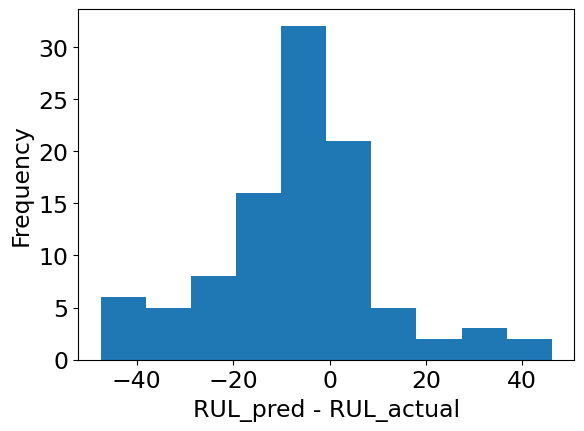

In [33]:
plt.figure()
plt.hist(errors_test)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('RUL_pred - RUL_actual',fontsize=17)
plt.ylabel('Frequency',fontsize=17)
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig('../reports/figures/fd'+str(ind)+'_hist_nofeat_c'+str(C)+'.png')

print(np.sum(errors_test < 0))